In [2]:
import sys
import math
import time
import random
sys.path.append("/github/meta_learning/np_variants/")

import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = (7.2, 4.8)

In [3]:
dtype = torch.double
device = torch.device("cuda")

In [4]:
class SineFunc:
    def __init__(self, amplitude_min=-1.0, amplitude_max=1.0, shift_min=-math.pi, shift_max=math.pi):
        self.amplitude_min = amplitude_min
        self.amplitude_max = amplitude_max

        self.shift_min = shift_min
        self.shift_max = shift_max

    def sample_data(self, num_tasks, num_samples):
        amplitude = torch.rand(num_tasks, 1, 1) * (self.amplitude_max - self.amplitude_min) + self.amplitude_min
        shift = torch.rand(num_tasks, 1, 1) * (self.shift_max - self.shift_min) + self.shift_min

        x = torch.rand((num_tasks, num_samples, 1)) * math.pi * 2 - math.pi
        y = amplitude * torch.sin((x - shift))
        return x, y, (amplitude.flatten(), shift.flatten())

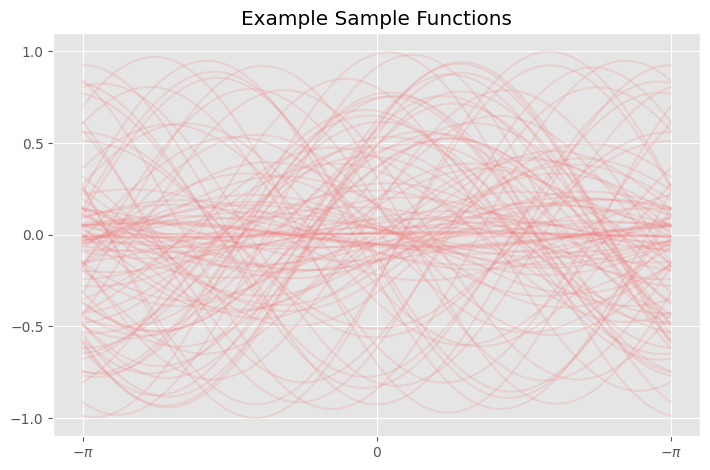

In [5]:
func = SineFunc()
_, _, (amplitude, shift) = func.sample_data(num_tasks=100, num_samples=20)

for i in range(100):
    x = torch.linspace(-math.pi, math.pi, 200)
    y = amplitude[i] * torch.sin((x - shift[i]))
    plt.plot(x.detach().numpy(), y.detach().numpy(), color="lightcoral", alpha=0.2)

plt.xticks(ticks=[-math.pi, 0, math.pi], labels=[r"$-\pi$", r"0", r"$-\pi$"])
plt.yticks(ticks=[-1.0, -0.5, 0, 0.5, 1.0])
plt.title("Example Sample Functions")
plt.tight_layout()

In [6]:
from models.np import NeuralProcess
from models.loss_functions import np_loss_func
from utils import context_target_split

In [7]:
lr=3e-4
batch_size = 64
num_samples = 400
num_epochs = 10000
print_epoch = 1000

num_context_min = 3
num_context_max = 200
num_extra_target_min = 0
num_extra_target_max = 200

In [8]:
model = NeuralProcess(x_dim=1, y_dim=1).to(dtype=dtype, device=device)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_func = np_loss_func

In [9]:
start_time = time.time()
for epoch in range(num_epochs):
    x_batch, y_batch, _ = func.sample_data(batch_size, num_samples)
    x_batch = x_batch.to(dtype=dtype, device=device)
    y_batch = y_batch.to(dtype=dtype, device=device)

    num_context = random.randint(num_context_min, num_context_max)
    num_extra_target = random.randint(num_extra_target_min, num_extra_target_max)

    x_context, y_context, x_target, y_target = context_target_split(x_batch, y_batch, num_context, num_extra_target)

    y_pred, q_context, q_target = model(x_context, y_context, x_target, y_target)
    
    optimizer.zero_grad()
    loss = loss_func(y_pred, y_target, q_context, q_target)
    loss.backward()
    optimizer.step()

    if (epoch+1) % print_epoch == 0:
        end_time = time.time()
        print(f"[{epoch+1}/{num_epochs}]\tLoss: {loss.item() / batch_size}\tTime: {end_time - start_time}")
        start_time = end_time

[999/10000]	Loss: -0.8610525546185668	Time: 145.0966923236847
[1999/10000]	Loss: -7.0573074223091625	Time: 142.91765022277832
[2999/10000]	Loss: -1.5997166422865186	Time: 146.34124875068665
[3999/10000]	Loss: -0.9473002898551475	Time: 146.02006077766418
[4999/10000]	Loss: -4.304055194224709	Time: 144.26753115653992
[5999/10000]	Loss: -5.284264652758743	Time: 139.3630931377411
[6999/10000]	Loss: 2.7503133865009595	Time: 144.035551071167
[7999/10000]	Loss: -9.464033760388622	Time: 141.91714429855347
[8999/10000]	Loss: -3.278783027791131	Time: 134.93295454978943
[9999/10000]	Loss: -0.8375209922313491	Time: 145.49414944648743


In [1]:
x_test, y_test, (amplitude, shift) = func.sample_data(num_tasks=1, num_samples=10)
x_grid = torch.linspace(-math.pi, math.pi, 1000)
y_grid = amplitude * torch.sin(x_grid - shift)
y_pred = model(x_test.to(dtype=dtype, device=device), y_test.to(dtype=dtype, device=device), x_grid.view(1, 1000, 1).to(dtype=dtype, device=device))

plt.scatter(x_test.detach().numpy().flatten(), y_test.detach().numpy().flatten(), marker="x", s=25, color="firebrick", zorder=2)
plt.plot(x_grid.detach().numpy(), y_grid.detach().numpy(), linestyle="--", color="lightcoral", label="Ground Trith")

plt.plot(x_grid.detach().numpy(), y_pred.loc.cpu().detach().numpy().flatten(), color="royalblue", label="NP")
plt.fill_between(x_grid.detach().numpy(), y_pred.loc.cpu().detach().numpy().flatten() - y_pred.scale.cpu().detach().numpy().flatten(),
                                          y_pred.loc.cpu().detach().numpy().flatten() + y_pred.scale.cpu().detach().numpy().flatten(), color="royalblue", alpha=0.2)

plt.title("Prediction of Neural Process")
plt.legend()
plt.tight_layout()

NameError: name 'func' is not defined